In [1]:
import pandas as pd
import numpy as np

#  plot confusion matrices
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

import sys
sys.path.insert(1, '../../')
from py_oqat.config_algorithms import ACOConfig
from py_oqat.classifier import OQATClassifier

In [2]:
# Load iris dataset from sklearn
df = pd.read_csv('../../datasets/hayes_roth.csv')
# df = pd.read_csv('datasets/car.csv')


# Separate features and labels into two dataframes
X = df.drop('class', axis=1)
y = df['class']

# Define the feature type for each column (discrete or continuous)
column_names = X.columns.to_list()
column_types = ['cat', 'cat', 'cat', 'cat']

# transform the dataframes into a numpy array
X = X.values
y = y.values

X = preprocessing.OrdinalEncoder().fit_transform(X)
y = preprocessing.LabelEncoder().fit_transform(y)

print(X.shape)
print(y.shape)

(132, 4)
(132,)


In [3]:
# Hypothesis: OQAT outperforms decision trees on small datasets

SEED = 42

training_sizes = [i / 100 for i in range(15, 95, 5)]
print(training_sizes)

runs = 10
decision_tree_models = []
oqat_models = []

decision_tree_runs = []
oqat_runs_bs_w = []
oqat_runs_bs_wn = []
oqat_runs_bs_d = []
oqat_runs_d_w = []
oqat_runs_d_wn = []
oqat_runs_d_d = []
for run in range(runs):
    decision_tree_results = []
    oqat_results_bs_w = []
    oqat_results_bs_wn = []
    oqat_results_bs_d = []
    oqat_results_d_w = []
    oqat_results_d_wn = []
    oqat_results_d_d = []


    for train_size in training_sizes:
        print(f"===== train size {train_size} ====")
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_size, random_state=SEED+run)
        
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        print("Distribution of training data")
        print(pd.Series(y_train).value_counts())

        # Train a decision tree classifier
        tree_model = DecisionTreeClassifier()
        tree_model.fit(X_train, y_train)
        y_pred_tree = tree_model.predict(X_test)
        cm_tree = confusion_matrix(y_test, y_pred_tree)
        tree_score = tree_model.score(X_test, y_test)
        print("Score decision tree: ", tree_score)
        decision_tree_results.append(tree_score)
        
        # Training data distribution with oqat
        aco_config = ACOConfig(algorithm="vertex-ac", cycles=20, ants=10, alpha=1, rho=0.99, tau_max=6., tau_min=0.01)
        classifier = OQATClassifier(collision_strategy="best_score", null_strategy="weighted", heuristic="aco", heuristic_config=aco_config)
        classifier.fit(X_train, y_train, column_names, column_types, n_discrete_bins=3)

        classifier.collision_strategy = "best_score"
        classifier.null_strategy = "weighted"
        y_pred_bs_w = classifier.predict(X_test, column_names)
        bs_w_score = classifier.score(y_pred_bs_w, y_test)
        print("Score oqat_bs_w: ", bs_w_score)
        oqat_results_bs_w.append(bs_w_score)

        classifier.collision_strategy = "best_score"
        classifier.null_strategy = "weighted_normalized"
        y_pred_bs_wn = classifier.predict(X_test, column_names)
        bs_wn_score = classifier.score(y_pred_bs_wn, y_test)
        print("Score oqat_bs_wn: ", bs_wn_score)
        oqat_results_bs_wn.append(bs_wn_score)

        classifier.collision_strategy = "best_score"
        classifier.null_strategy = "dissimilarity"
        y_pred_bs_d = classifier.predict(X_test, column_names)
        bs_d_score = classifier.score(y_pred_bs_d, y_test)
        print("Score oqat_bs_d: ", bs_d_score)
        oqat_results_bs_d.append(bs_d_score)

        classifier.collision_strategy = "dissimilarity"
        classifier.null_strategy = "weighted"
        y_pred_d_w = classifier.predict(X_test, column_names)
        d_w_score = classifier.score(y_pred_d_w, y_test)
        print("Score oqat_d_w: ", d_w_score)
        oqat_results_d_w.append(d_w_score)

        classifier.collision_strategy = "dissimilarity"
        classifier.null_strategy = "weighted_normalized"
        y_pred_d_wn = classifier.predict(X_test, column_names)
        d_wn_score = classifier.score(y_pred_d_wn, y_test)
        print("Score oqat_d_wn: ", d_wn_score)
        oqat_results_d_wn.append(d_wn_score)

        classifier.collision_strategy = "dissimilarity"
        classifier.null_strategy = "dissimilarity"
        y_pred_d_d = classifier.predict(X_test, column_names)
        d_d_score = classifier.score(y_pred_d_d, y_test)
        print("Score oqat_d_d: ", d_d_score)
        oqat_results_d_d.append(d_d_score)

    decision_tree_runs.append(decision_tree_results)
    oqat_runs_bs_w.append(oqat_results_bs_w)
    oqat_runs_bs_wn.append(oqat_results_bs_wn)
    oqat_runs_bs_d.append(oqat_results_bs_d)
    oqat_runs_d_w.append(oqat_results_d_w)
    oqat_runs_d_wn.append(oqat_results_d_wn)
    oqat_runs_d_d.append(oqat_results_d_d)

    decision_tree_models.append(tree_model)
    oqat_models.append(classifier)


[0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
===== train size 0.15 ====
(19, 4) (19,) (113, 4) (113,)
Distribution of training data
1    9
2    6
0    4
dtype: int64
Score decision tree:  0.584070796460177
Score oqat_bs_w:  0.5398230088495575
Score oqat_bs_wn:  0.5398230088495575
Score oqat_bs_d:  0.5398230088495575
Score oqat_d_w:  0.45132743362831856
Score oqat_d_wn:  0.45132743362831856
Score oqat_d_d:  0.45132743362831856
===== train size 0.2 ====
(26, 4) (26,) (106, 4) (106,)
Distribution of training data
1    13
2     7
0     6
dtype: int64
Score decision tree:  0.5283018867924528
Score oqat_bs_w:  0.6509433962264151
Score oqat_bs_wn:  0.5943396226415094
Score oqat_bs_d:  0.6226415094339622
Score oqat_d_w:  0.5754716981132075
Score oqat_d_wn:  0.5188679245283019
Score oqat_d_d:  0.5471698113207547
===== train size 0.25 ====
(33, 4) (33,) (99, 4) (99,)
Distribution of training data
1    15
0    10
2     8
dtype: int64
Score decision tree

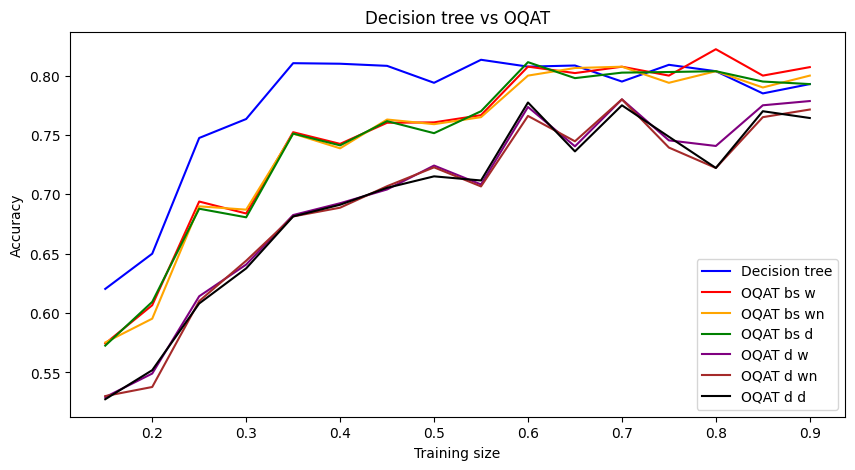

In [5]:

# compute mean and std
decision_tree_mean = np.mean(decision_tree_runs, axis=0)
decision_tree_std = np.std(decision_tree_runs, axis=0)
oqat_mean_bs_w = np.mean(oqat_runs_bs_w, axis=0)
oqat_std_bs_w = np.std(oqat_runs_bs_w, axis=0)
oqat_mean_bs_wn = np.mean(oqat_runs_bs_wn, axis=0)
oqat_std_bs_wn = np.std(oqat_runs_bs_wn, axis=0)
oqat_mean_bs_d = np.mean(oqat_runs_bs_d, axis=0)
oqat_std_bs_d = np.std(oqat_runs_bs_d, axis=0)
oqat_mean_d_w = np.mean(oqat_runs_d_w, axis=0)
oqat_std_d_w = np.std(oqat_runs_d_w, axis=0)
oqat_mean_d_wn = np.mean(oqat_runs_d_wn, axis=0)
oqat_std_d_wn = np.std(oqat_runs_d_wn, axis=0)
oqat_mean_d_d = np.mean(oqat_runs_d_d, axis=0)
oqat_std_d_d = np.std(oqat_runs_d_d, axis=0)

# plot means and atd for every model at every training size
plt.figure(figsize=(10, 5))
plt.title("Decision tree vs OQAT")
plt.plot(training_sizes, decision_tree_mean, label="Decision tree", color="blue")
# plt.fill_between(training_sizes, decision_tree_mean - decision_tree_std, decision_tree_mean + decision_tree_std, alpha=0.2, color="blue")
plt.plot(training_sizes, oqat_mean_bs_w, label="OQAT bs w", color="red")
# plt.fill_between(training_sizes, oqat_mean_bs_w - oqat_std_bs_w, oqat_mean_bs_w + oqat_std_bs_w, alpha=0.2, color="red")
plt.plot(training_sizes, oqat_mean_bs_wn, label="OQAT bs wn", color="orange")
# plt.fill_between(training_sizes, oqat_mean_bs_wn - oqat_std_bs_wn, oqat_mean_bs_wn + oqat_std_bs_wn, alpha=0.2, color="orange")
plt.plot(training_sizes, oqat_mean_bs_d, label="OQAT bs d", color="green")
# plt.fill_between(training_sizes, oqat_mean_bs_d - oqat_std_bs_d, oqat_mean_bs_d + oqat_std_bs_d, alpha=0.2, color="green")
plt.plot(training_sizes, oqat_mean_d_w, label="OQAT d w", color="purple")
# plt.fill_between(training_sizes, oqat_mean_d_w - oqat_std_d_w, oqat_mean_d_w + oqat_std_d_w, alpha=0.2, color="purple")
plt.plot(training_sizes, oqat_mean_d_wn, label="OQAT d wn", color="brown")
# plt.fill_between(training_sizes, oqat_mean_d_wn - oqat_std_d_wn, oqat_mean_d_wn + oqat_std_d_wn, alpha=0.2, color="brown")
plt.plot(training_sizes, oqat_mean_d_d, label="OQAT d d", color="black")
# plt.fill_between(training_sizes, oqat_mean_d_d - oqat_std_d_d, oqat_mean_d_d + oqat_std_d_d, alpha=0.2, color="black")

plt.xlabel("Training size")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
